In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder\
                    .appName("Analyzing London Crime Data")\
                    .getOrCreate() #get the session or create a new session

In [78]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("./london_crime_by_lsoa.csv")

AnalysisException: 'Path does not exist: file:/C:/Users/320008048/pyspark/london_crime_by_lsoa.csv;'

In [7]:
data.count()

13490604

In [8]:
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [11]:
data.limit(2).show()

+---------+---------+--------------------+--------------------+-----+----+-----+
|lsoa_code|  borough|      major_category|      minor_category|value|year|month|
+---------+---------+--------------------+--------------------+-----+----+-----+
|E01001116|  Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646|Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
+---------+---------+--------------------+--------------------+-----+----+-----+



In [12]:
data.dropna() # Drop values that have missing info

DataFrame[lsoa_code: string, borough: string, major_category: string, minor_category: string, value: string, year: string, month: string]

In [13]:
data = data.drop("lsoa_code")

data.show(5)

+----------+--------------------+--------------------+-----+----+-----+
|   borough|      major_category|      minor_category|value|year|month|
+----------+--------------------+--------------------+-----+----+-----+
|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [15]:
total_borough = data.select("borough")\
                    .distinct()

total_borough.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [16]:
croydon_data = data.filter(data['borough'] == 'Croydon')

croydon_data.show(5)

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|Croydon|               Drugs| Possession Of Drugs|    0|2010|   12|
|Croydon|  Theft and Handling|         Other Theft|    1|2014|    5|
|Croydon|Violence Against ...|    Offensive Weapon|    0|2012|   12|
|Croydon|               Drugs|    Drug Trafficking|    0|2008|    2|
+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [34]:
data_15_16 = data.filter(data['year'].isin([2015, 2016]))
data_15_16.sample(fraction=0.1).show(5)

+--------------+--------------------+--------------------+-----+----+-----+
|       borough|      major_category|      minor_category|value|year|month|
+--------------+--------------------+--------------------+-----+----+-----+
|      Hounslow|     Criminal Damage|Criminal Damage T...|    0|2015|    2|
|Waltham Forest|Other Notifiable ...|      Going Equipped|    0|2015|    2|
|        Sutton|Violence Against ...|        Wounding/GBH|    0|2016|    7|
|      Hounslow|Violence Against ...|    Offensive Weapon|    1|2015|   10|
|       Lambeth|Violence Against ...|      Other violence|    0|2016|    7|
+--------------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [28]:
data_above_14 = data.filter(data['year'] > 2014)
assert data_above_14.count() == data_15_16.count(), "Same to same, lol!"

In [32]:
borough_conviction_crime_sum = data.groupBy('borough')\
                        .agg({"value":"sum"}) # Very efficient over RDD. RDD only apply to key-values

borough_conviction_crime_sum.show(5)

+--------------------+----------+
|             borough|sum(value)|
+--------------------+----------+
|             Croydon|  260294.0|
|          Wandsworth|  204741.0|
|              Bexley|  114136.0|
|             Lambeth|  292178.0|
|Barking and Dagenham|  149447.0|
+--------------------+----------+
only showing top 5 rows



In [36]:
borough_conviction_crime_sum = data.groupBy('borough')\
                        .agg({"value":"sum"})\
                        .withColumnRenamed("sum(value)", "convictions")

borough_conviction_crime_sum.show(5)`

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|   260294.0|
|          Wandsworth|   204741.0|
|              Bexley|   114136.0|
|             Lambeth|   292178.0|
|Barking and Dagenham|   149447.0|
+--------------------+-----------+
only showing top 5 rows



In [37]:
total_borough_convictions = borough_conviction_crime_sum.agg({"convictions":"sum"})

total_borough_convictions.show()

+----------------+
|sum(convictions)|
+----------------+
|       6447758.0|
+----------------+



In [40]:
total_convictions = total_borough_convictions.collect()[0][0]
total_convictions

6447758.0

In [41]:
import pyspark.sql.functions as func

In [51]:
borough_perc_contribution = borough_conviction_crime_sum.withColumn("% Contribution",
                                                                   func.round(borough_conviction_crime_sum.convictions / total_convictions * 100, 2))

borough_perc_contribution.orderBy(borough_perc_contribution[2].desc()).show(5)

+-----------+-----------+--------------+
|    borough|convictions|% Contribution|
+-----------+-----------+--------------+
|Westminster|   455028.0|          7.06|
|    Lambeth|   292178.0|          4.53|
|  Southwark|   278809.0|          4.32|
|     Camden|   275147.0|          4.27|
|     Newham|   262024.0|          4.06|
+-----------+-----------+--------------+
only showing top 5 rows



In [61]:
conviction_monthly = data.filter(data["year"] > 2014) \
                         .groupBy("month")\
                         .agg({"value":"sum"})\
                         .withColumnRenamed("sum(value)","convictions")
conviction_monthly.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|    7|   127125.0|
|   11|   123551.0|
|    3|   119263.0|
|    8|   120722.0|
|    5|   125028.0|
|    6|   123022.0|
|    9|   118976.0|
|    1|   115902.0|
|   10|   125766.0|
|    4|   115082.0|
|   12|   123295.0|
|    2|   110013.0|
+-----+-----------+



In [62]:
crimes_category = data.groupBy("major_category")\
                      .agg({"value":"sum"})\
                      .withColumnRenamed("sum(value)","convictions")

crimes_category.orderBy(crimes_category.convictions.desc()).show()

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|  Theft and Handling|  2661861.0|
|Violence Against ...|  1558081.0|
|            Burglary|   754293.0|
|     Criminal Damage|   630938.0|
|               Drugs|   470765.0|
|             Robbery|   258873.0|
|Other Notifiable ...|   106349.0|
|    Fraud or Forgery|     5325.0|
|     Sexual Offences|     1273.0|
+--------------------+-----------+



In [66]:
year_df = data.select("year")
year_df.agg({"year":"max"}).show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [67]:
year_df.describe().show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|          13490604|
|   mean|            2012.0|
| stddev|2.5819889931674522|
|    min|              2008|
|    max|              2016|
+-------+------------------+



In [70]:
data.crosstab("borough", "major_category")\
    .select("borough_major_category", "Burglary", "Drugs", "Fraud or Forgery").show()

+----------------------+--------+-----+----------------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|
+----------------------+--------+-----+----------------+
|              Havering|   32400|32616|            5508|
|                Merton|   26784|29160|            5724|
|              Haringey|   31320|35424|           10368|
|         Tower Hamlets|   31104|37368|            5400|
|               Bromley|   42552|42336|            8532|
|               Enfield|   39528|44064|            9720|
|  Kingston upon Thames|   21168|22140|            3780|
|           Westminster|   27648|32616|            8748|
|  Richmond upon Thames|   24840|23004|            2808|
|              Lewisham|   36504|43740|           11016|
|                 Brent|   37368|46980|            9288|
|  Barking and Dagenham|   23760|26244|            7236|
|             Redbridge|   34776|36504|            8532|
|             Islington|   26568|34128|            5184|
|               Hackney|   3110

In [71]:
get_ipython().magic("matplotlib inline")
import matplotlib.pyplot as plt
plt.style.use("ggplot")

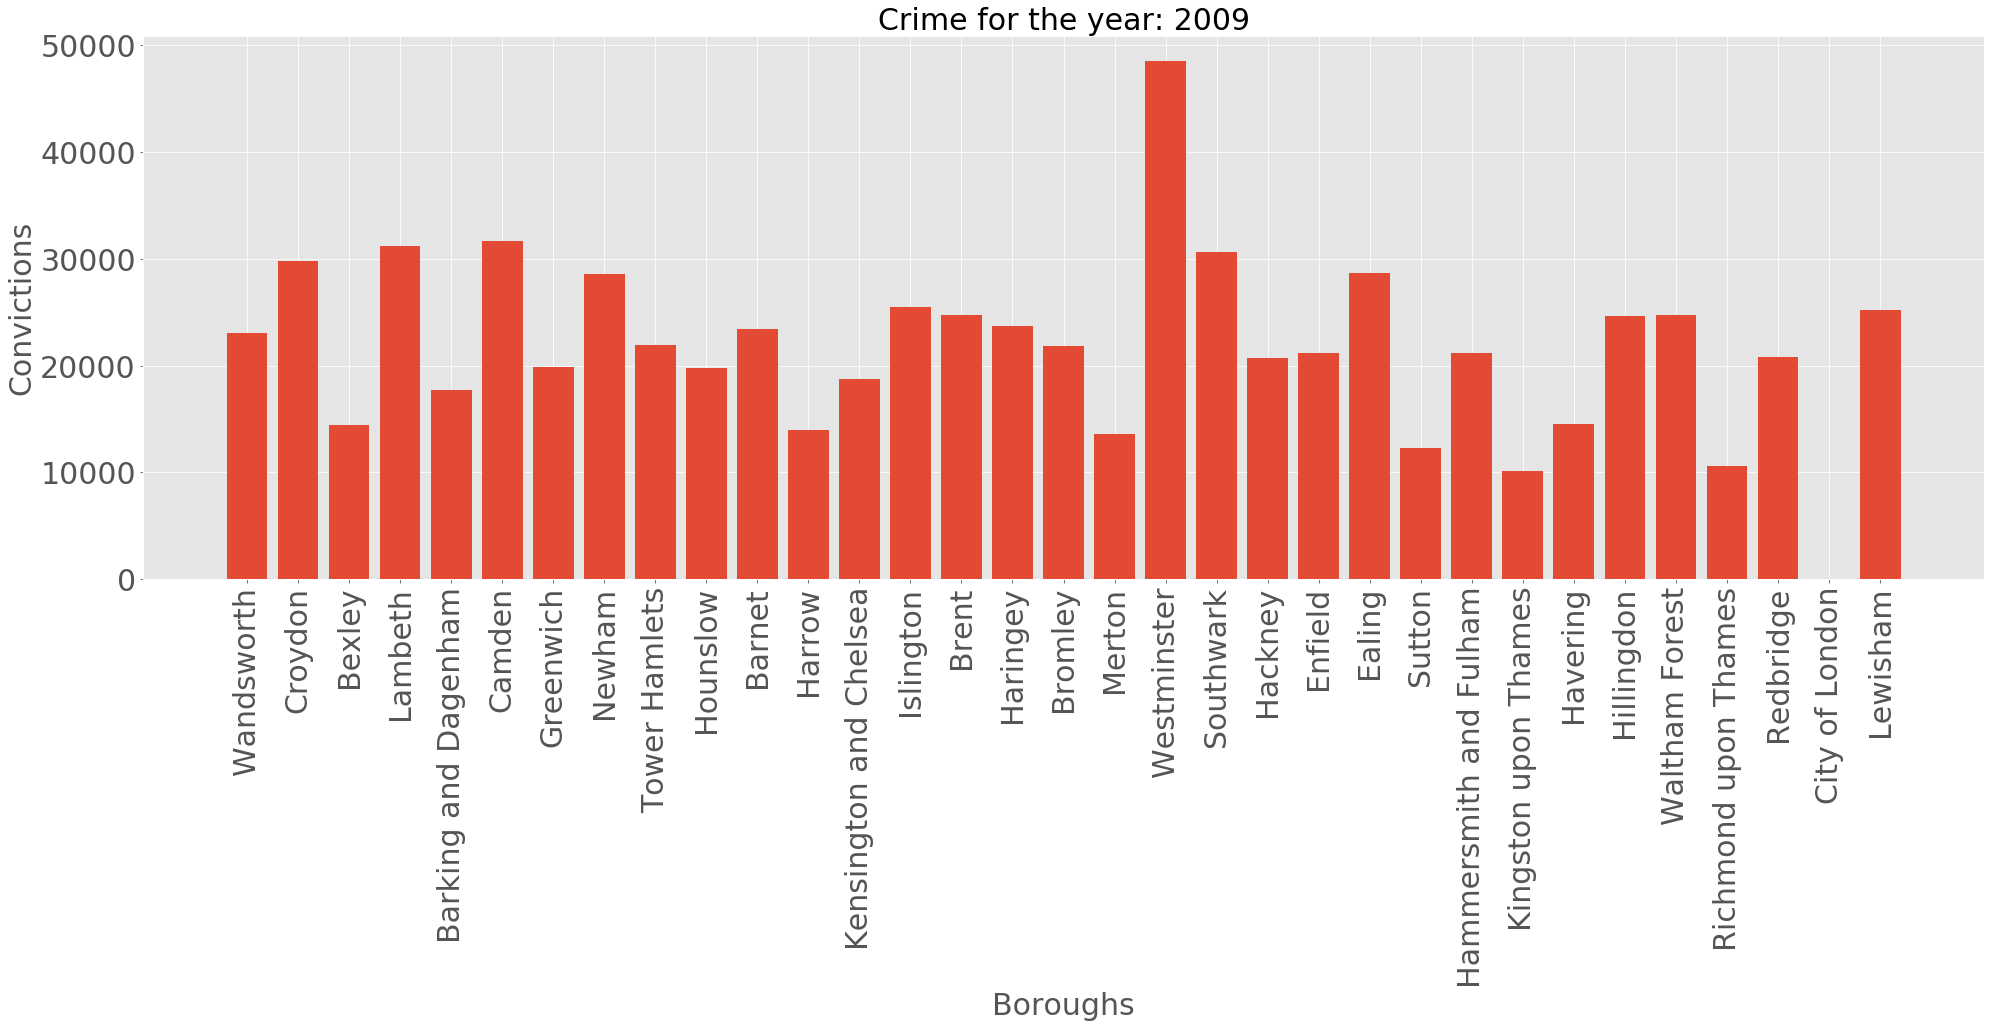

In [76]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy("borough")\
                         .agg({"value":"sum"})\
                         .withColumnRenamed("sum(value)","convictions")
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
    
    plt.figure(figsize=(33, 10))
    plt.bar(borough_list,convictions_list)
    
    plt.title("Crime for the year: " + str(year), fontsize=30)
    plt.xlabel("Boroughs", fontsize=30)
    plt.ylabel("Convictions", fontsize=30)
    
    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()
    
describe_year(2009)